In [2]:
import os
import gc
import warnings
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from typing import Tuple, List, Dict, Optional
from pathlib import Path
import cv2
from tqdm import tqdm

# Scientific computing
import pydicom
import nibabel as nib
from scipy import ndimage
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report

# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

# Visualization
plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')

In [3]:
# Configuration
class Config:
    # Data paths
    DATA_PATH = "/kaggle/input/rsna-intracranial-aneurysm-detection"
    SERIES_PATH = f"{DATA_PATH}/series"
    SEGMENTATION_PATH = f"{DATA_PATH}/segmentations"
    CACHE_PATH = "/kaggle/working/cache"
    
    # Model settings
    TARGET_SIZE_2D = (512, 512)
    TARGET_SIZE_3D = (64, 64, 64)
    BATCH_SIZE = 16
    NUM_EPOCHS = 50
    LEARNING_RATE = 1e-3
    
    # Training
    N_FOLDS = 5
    SEED = 42
    USE_SUBSET = True  # Use subset for faster training
    SUBSET_RATIO = 0.3  # Use 30% of data for efficiency
    
    # Device
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Labels
    LABEL_COLS = [
        'Left Infraclinoid Internal Carotid Artery',
        'Right Infraclinoid Internal Carotid Artery',
        'Left Supraclinoid Internal Carotid Artery',
        'Right Supraclinoid Internal Carotid Artery',
        'Left Middle Cerebral Artery',
        'Right Middle Cerebral Artery',
        'Anterior Communicating Artery',
        'Left Anterior Cerebral Artery',
        'Right Anterior Cerebral Artery',
        'Left Posterior Communicating Artery',
        'Right Posterior Communicating Artery',
        'Basilar Tip',
        'Other Posterior Circulation',
        'Aneurysm Present'
    ]

config = Config()
os.makedirs(config.CACHE_PATH, exist_ok=True)

print(f"Running on: {config.DEVICE}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


Running on: cuda
PyTorch version: 2.6.0+cu124
CUDA available: True


Training data shape: (4348, 18)
Localizer data shape: (2254, 4)


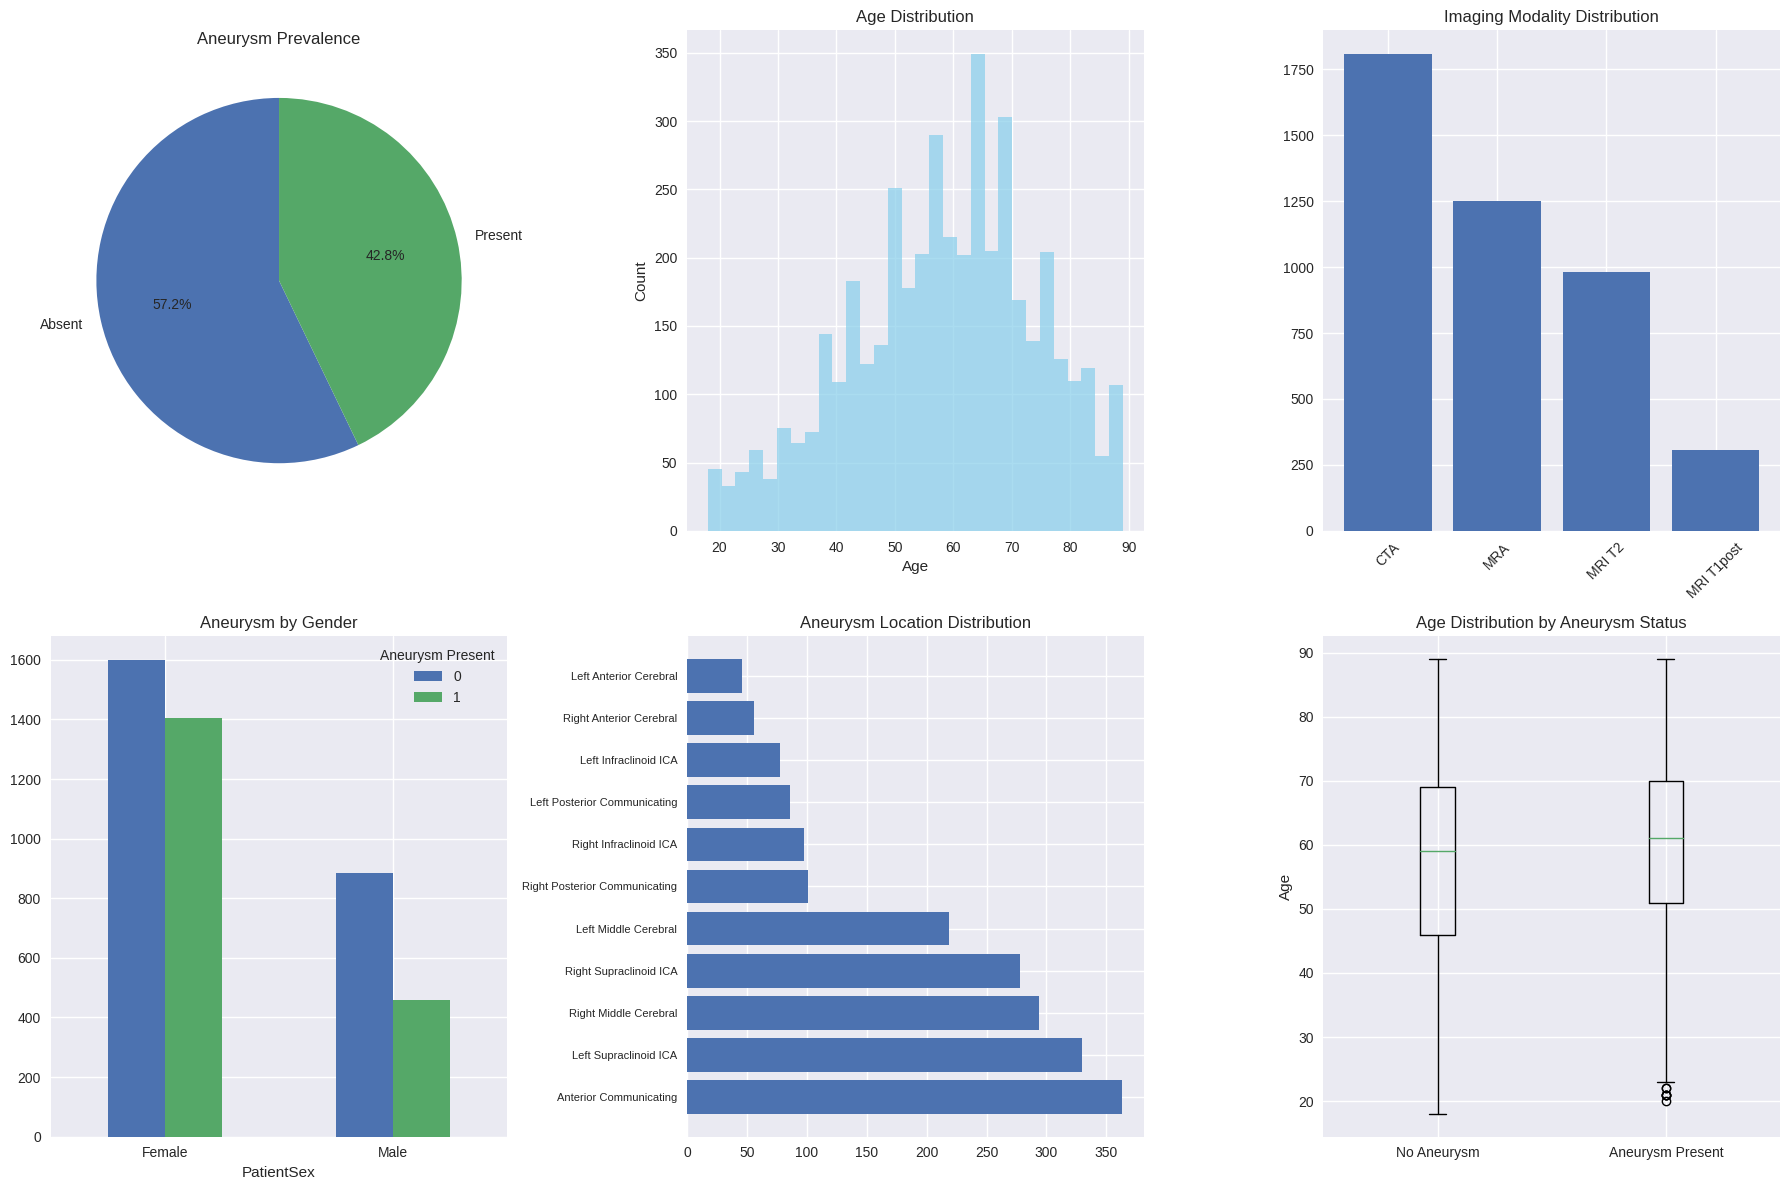


=== DATA SUMMARY ===
Total samples: 4348
Aneurysm prevalence: 0.428
Average age: 58.5 ± 15.8
Gender distribution: {'Female': 3005, 'Male': 1343}
Modality distribution: {'CTA': 1808, 'MRA': 1252, 'MRI T2': 983, 'MRI T1post': 305}

=== LOCATION-WISE PREVALENCE ===
Left Infraclinoid Internal Carotid Artery: 0.018
Right Infraclinoid Internal Carotid Artery: 0.023
Left Supraclinoid Internal Carotid Artery: 0.076
Right Supraclinoid Internal Carotid Artery: 0.064
Left Middle Cerebral Artery: 0.050
Right Middle Cerebral Artery: 0.068
Anterior Communicating Artery: 0.083
Left Anterior Cerebral Artery: 0.011
Right Anterior Cerebral Artery: 0.013
Left Posterior Communicating Artery: 0.020
Right Posterior Communicating Artery: 0.023


In [4]:
# =============================================================================
# DATA LOADING AND EXPLORATION
# =============================================================================

# Load metadata
train_df = pd.read_csv(f"{config.DATA_PATH}/train.csv")
localizer_df = pd.read_csv(f"{config.DATA_PATH}/train_localizers.csv")

print(f"Training data shape: {train_df.shape}")
print(f"Localizer data shape: {localizer_df.shape}")

# Data exploration with visualizations
def explore_data():
    """Comprehensive data exploration with visualizations"""
    
    # Class distribution
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Aneurysm prevalence
    aneurysm_counts = train_df['Aneurysm Present'].value_counts()
    axes[0, 0].pie(aneurysm_counts.values, labels=['Absent', 'Present'], 
                   autopct='%1.1f%%', startangle=90)
    axes[0, 0].set_title('Aneurysm Prevalence')
    
    # Age distribution
    axes[0, 1].hist(train_df['PatientAge'], bins=30, alpha=0.7, color='skyblue')
    axes[0, 1].set_xlabel('Age')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].set_title('Age Distribution')
    
    # Modality distribution
    modality_counts = train_df['Modality'].value_counts()
    axes[0, 2].bar(modality_counts.index, modality_counts.values)
    axes[0, 2].set_title('Imaging Modality Distribution')
    axes[0, 2].tick_params(axis='x', rotation=45)
    
    # Gender vs Aneurysm
    gender_aneurysm = pd.crosstab(train_df['PatientSex'], train_df['Aneurysm Present'])
    gender_aneurysm.plot(kind='bar', ax=axes[1, 0])
    axes[1, 0].set_title('Aneurysm by Gender')
    axes[1, 0].tick_params(axis='x', rotation=0)
    
    # Location-wise aneurysm distribution
    location_cols = [col for col in config.LABEL_COLS if 'Artery' in col or 'Communicating' in col]
    location_prevalence = train_df[location_cols].sum().sort_values(ascending=False)
    
    axes[1, 1].barh(range(len(location_prevalence)), location_prevalence.values)
    axes[1, 1].set_yticks(range(len(location_prevalence)))
    axes[1, 1].set_yticklabels([col.replace(' Artery', '').replace('Internal Carotid', 'ICA') 
                               for col in location_prevalence.index], fontsize=8)
    axes[1, 1].set_title('Aneurysm Location Distribution')
    
    # Age vs Aneurysm correlation
    axes[1, 2].boxplot([train_df[train_df['Aneurysm Present']==0]['PatientAge'], 
                       train_df[train_df['Aneurysm Present']==1]['PatientAge']])
    axes[1, 2].set_xticklabels(['No Aneurysm', 'Aneurysm Present'])
    axes[1, 2].set_ylabel('Age')
    axes[1, 2].set_title('Age Distribution by Aneurysm Status')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n=== DATA SUMMARY ===")
    print(f"Total samples: {len(train_df)}")
    print(f"Aneurysm prevalence: {train_df['Aneurysm Present'].mean():.3f}")
    print(f"Average age: {train_df['PatientAge'].mean():.1f} ± {train_df['PatientAge'].std():.1f}")
    print(f"Gender distribution: {train_df['PatientSex'].value_counts().to_dict()}")
    print(f"Modality distribution: {train_df['Modality'].value_counts().to_dict()}")
    
    # Location-wise statistics
    print(f"\n=== LOCATION-WISE PREVALENCE ===")
    for col in location_cols:
        prevalence = train_df[col].mean()
        print(f"{col}: {prevalence:.3f}")

explore_data()

In [5]:
# =============================================================================
# ADVANCED DATA PREPROCESSING
# =============================================================================

class AdvancedDICOMProcessor:
    """Advanced DICOM processing with medical imaging best practices"""
    
    def __init__(self, target_size_2d: Tuple[int, int] = config.TARGET_SIZE_2D,
                 target_size_3d: Tuple[int, int, int] = config.TARGET_SIZE_3D):
        self.target_size_2d = target_size_2d
        self.target_size_3d = target_size_3d
        
        # HU windowing presets for different anatomies
        self.window_presets = {
            'brain': (40, 80),      # Brain window
            'angio': (600, 150),    # Angiography window  
            'bone': (400, 1000),    # Bone window
            'soft': (400, 50)       # Soft tissue window
        }
    
    def load_dicom_series(self, series_path: str, return_metadata: bool = False) -> np.ndarray:
        """Load and process DICOM series with proper ordering and metadata extraction"""
        
        try:
            # Get all DICOM files
            dicom_files = []
            for root, _, files in os.walk(series_path):
                for file in files:
                    if file.endswith('.dcm'):
                        dicom_files.append(os.path.join(root, file))
            
            if not dicom_files:
                raise ValueError(f"No DICOM files found in {series_path}")
            
            # Load DICOMs with position information
            dicoms_with_info = []
            for filepath in dicom_files:
                try:
                    ds = pydicom.dcmread(filepath, force=True)
                    if hasattr(ds, 'PixelData'):
                        # Get spatial information
                        z_pos = None
                        if hasattr(ds, 'ImagePositionPatient') and len(ds.ImagePositionPatient) >= 3:
                            try:
                                z_pos = float(ds.ImagePositionPatient[2])
                            except (ValueError, TypeError):
                                pass
                        
                        instance_num = getattr(ds, 'InstanceNumber', 0)
                        dicoms_with_info.append((ds, filepath, z_pos, instance_num))
                        
                except Exception as e:
                    continue
            
            if not dicoms_with_info:
                raise ValueError(f"No valid DICOM files with pixel data in {series_path}")
            
            # Sort by Z-position (preferred) or InstanceNumber
            valid_z_pos = [info for info in dicoms_with_info if info[2] is not None]
            if valid_z_pos:
                dicoms_with_info.sort(key=lambda x: x[2])  # Sort by Z-position
            else:
                dicoms_with_info.sort(key=lambda x: x[3])  # Sort by InstanceNumber
            
            # Extract volume and metadata
            volume_slices = []
            spacing = None
            
            for ds, _, _, _ in dicoms_with_info:
                try:
                    pixel_array = ds.pixel_array.astype(np.float32)
                    
                    # Apply rescale if available (convert to HU)
                    if hasattr(ds, 'RescaleSlope') and hasattr(ds, 'RescaleIntercept'):
                        slope = float(ds.RescaleSlope)
                        intercept = float(ds.RescaleIntercept)
                        pixel_array = pixel_array * slope + intercept
                    
                    # Get pixel spacing for first slice
                    if spacing is None and hasattr(ds, 'PixelSpacing'):
                        try:
                            spacing = [float(ds.PixelSpacing[0]), float(ds.PixelSpacing[1])]
                            if hasattr(ds, 'SliceThickness'):
                                spacing.append(float(ds.SliceThickness))
                            else:
                                spacing.append(1.0)
                        except:
                            spacing = [1.0, 1.0, 1.0]
                    
                    volume_slices.append(pixel_array)
                    
                except Exception as e:
                    continue
            
            if not volume_slices:
                raise ValueError("No valid slices extracted")
            
            # Stack into 3D volume
            volume = np.stack(volume_slices, axis=0)
            
            if return_metadata:
                metadata = {
                    'spacing': spacing or [1.0, 1.0, 1.0],
                    'modality': getattr(dicoms_with_info[0][0], 'Modality', 'Unknown'),
                    'shape': volume.shape
                }
                return volume, metadata
            
            return volume
            
        except Exception as e:
            print(f"Error processing series {series_path}: {e}")
            return np.zeros(self.target_size_3d, dtype=np.float32)
    
    def apply_windowing(self, volume: np.ndarray, window_type: str = 'brain') -> np.ndarray:
        """Apply HU windowing for better tissue contrast"""
        
        if window_type not in self.window_presets:
            return volume
        
        center, width = self.window_presets[window_type]
        min_val = center - width // 2
        max_val = center + width // 2
        
        # Apply windowing
        windowed = np.clip(volume, min_val, max_val)
        windowed = (windowed - min_val) / (max_val - min_val)
        
        return windowed.astype(np.float32)
    
    def preprocess_volume_3d(self, volume: np.ndarray) -> np.ndarray:
        """Preprocess 3D volume for 3D CNN"""
        
        if volume.size == 0:
            return np.zeros(self.target_size_3d, dtype=np.float32)
        
        # Apply brain windowing
        volume = self.apply_windowing(volume, 'brain')
        
        # Resize to target size
        if volume.shape != self.target_size_3d:
            zoom_factors = [self.target_size_3d[i] / volume.shape[i] for i in range(3)]
            volume = ndimage.zoom(volume, zoom_factors, order=1)
        
        return volume.astype(np.float32)
    
    def extract_2d_slices(self, volume: np.ndarray, num_slices: int = 5) -> List[np.ndarray]:
        """Extract key 2D slices from 3D volume"""
        
        depth = volume.shape[0]
        
        # Extract slices from different depths
        slice_indices = np.linspace(depth//4, 3*depth//4, num_slices, dtype=int)
        slices = []
        
        for idx in slice_indices:
            slice_2d = volume[idx]
            # Resize to target 2D size
            slice_2d = cv2.resize(slice_2d, self.target_size_2d)
            slices.append(slice_2d)
        
        return slices


In [6]:
# =============================================================================
# ADVANCED MODEL ARCHITECTURES
# =============================================================================

class SEBlock(nn.Module):
    """Squeeze-and-Excitation Block for channel attention"""
    
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc1 = nn.Conv2d(channels, channels // reduction, 1)
        self.fc2 = nn.Conv2d(channels // reduction, channels, 1)
        
    def forward(self, x):
        w = F.adaptive_avg_pool2d(x, 1)
        w = F.relu(self.fc1(w))
        w = torch.sigmoid(self.fc2(w))
        return x * w

class CBAM(nn.Module):
    """Convolutional Block Attention Module"""
    
    def __init__(self, channels):
        super().__init__()
        self.channel_attention = SEBlock(channels)
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, 7, padding=3),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # Channel attention
        x = self.channel_attention(x)
        
        # Spatial attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_input = torch.cat([avg_out, max_out], dim=1)
        spatial_weight = self.spatial_attention(spatial_input)
        
        return x * spatial_weight

class Advanced2DCNN(nn.Module):
    """Advanced 2D CNN with attention mechanisms"""
    
    def __init__(self, num_classes: int = len(config.LABEL_COLS), backbone: str = 'efficientnet'):
        super().__init__()
        
        # Backbone
        if backbone == 'efficientnet':
            from torchvision.models import efficientnet_b2
            self.backbone = efficientnet_b2(pretrained=True)
            backbone_out = 1408
            # Replace first conv for multi-channel input (brain windowing)
            self.backbone.features[0][0] = nn.Conv2d(3, 32, 3, stride=2, padding=1, bias=False)
        else:
            from torchvision.models import resnet50
            self.backbone = resnet50(pretrained=True)
            backbone_out = 2048
            self.backbone.conv1 = nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False)
        
        # Remove classifier
        if hasattr(self.backbone, 'classifier'):
            self.backbone.classifier = nn.Identity()
        else:
            self.backbone.fc = nn.Identity()
        
        # Attention modules
        self.attention = CBAM(backbone_out)
        
        # Custom classifier with dropout
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(backbone_out, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # Extract features
        features = self.backbone(x)
        
        # Apply attention if features are 4D (conv features)
        if len(features.shape) == 4:
            features = self.attention(features)
        
        # Classification
        return self.classifier(features)

class Advanced3DCNN(nn.Module):
    """Lightweight but effective 3D CNN"""
    
    def __init__(self, num_classes: int = len(config.LABEL_COLS)):
        super().__init__()
        
        # 3D Convolutional layers
        self.conv_layers = nn.Sequential(
            # Block 1
            nn.Conv3d(1, 32, 3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d(2),
            
            # Block 2  
            nn.Conv3d(32, 64, 3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(2),
            
            # Block 3
            nn.Conv3d(64, 128, 3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.MaxPool3d(2),
            
            # Block 4
            nn.Conv3d(128, 256, 3, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((2, 2, 2))
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        return self.classifier(x)

In [7]:
# =============================================================================
# DATASET CLASSES WITH AUGMENTATIONS
# =============================================================================

class AneurysmDataset2D(Dataset):
    """2D Dataset with advanced augmentations"""
    
    def __init__(self, dataframe: pd.DataFrame, series_dir: str, processor: AdvancedDICOMProcessor,
                 mode: str = 'train', transform=None):
        self.dataframe = dataframe
        self.series_dir = series_dir
        self.processor = processor
        self.mode = mode
        self.transform = transform
        
        # Cache for processed volumes
        self.volume_cache = {}
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        series_id = row['SeriesInstanceUID']
        
        # Load or get cached volume
        if series_id not in self.volume_cache:
            series_path = os.path.join(self.series_dir, series_id)
            volume = self.processor.load_dicom_series(series_path)
            self.volume_cache[series_id] = volume
        else:
            volume = self.volume_cache[series_id]
        
        # Extract 2D slices
        slices = self.processor.extract_2d_slices(volume, num_slices=3)
        
        # Stack as 3-channel image (different slices as channels)
        image = np.stack(slices, axis=0)  # Shape: (3, H, W)
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        # Get labels
        labels = row[config.LABEL_COLS].values.astype(np.float32)
        
        return torch.FloatTensor(image), torch.FloatTensor(labels)

class AneurysmDataset3D(Dataset):
    """3D Dataset for volumetric analysis"""
    
    def __init__(self, dataframe: pd.DataFrame, series_dir: str, processor: AdvancedDICOMProcessor,
                 mode: str = 'train'):
        self.dataframe = dataframe
        self.series_dir = series_dir
        self.processor = processor
        self.mode = mode
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        series_id = row['SeriesInstanceUID']
        
        # Load and process volume
        series_path = os.path.join(self.series_dir, series_id)
        volume = self.processor.load_dicom_series(series_path)
        volume = self.processor.preprocess_volume_3d(volume)
        
        # Add channel dimension
        volume = volume[np.newaxis, ...]  # Shape: (1, D, H, W)
        
        # Get labels
        labels = row[config.LABEL_COLS].values.astype(np.float32)
        
        return torch.FloatTensor(volume), torch.FloatTensor(labels)

# Augmentation transforms
train_transforms_2d = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(config.TARGET_SIZE_2D, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

val_transforms_2d = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(config.TARGET_SIZE_2D),
    transforms.ToTensor(),
])

In [8]:
# =============================================================================
# ADVANCED LOSS FUNCTIONS
# =============================================================================

class FocalLoss(nn.Module):
    """Focal Loss for addressing class imbalance"""
    
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class WeightedBCELoss(nn.Module):
    """Weighted BCE loss for multi-label classification"""
    
    def __init__(self, pos_weights=None):
        super().__init__()
        self.pos_weights = pos_weights
        
    def forward(self, inputs, targets):
        if self.pos_weights is not None:
            return F.binary_cross_entropy(inputs, targets, weight=self.pos_weights)
        else:
            return F.binary_cross_entropy(inputs, targets)

def compute_class_weights(dataframe: pd.DataFrame) -> torch.Tensor:
    """Compute class weights for imbalanced dataset"""
    weights = []
    for col in config.LABEL_COLS:
        pos_count = dataframe[col].sum()
        neg_count = len(dataframe) - pos_count
        weight = neg_count / (pos_count + 1e-6)  # Add small epsilon to avoid division by zero
        weights.append(weight)
    return torch.FloatTensor(weights)

In [9]:
# =============================================================================
# TRAINING PIPELINE
# =============================================================================

class ModelTrainer:
    """Advanced model trainer with cross-validation and ensembling"""
    
    def __init__(self, model_type: str = '2d'):
        self.model_type = model_type
        self.processor = AdvancedDICOMProcessor()
        
        # Initialize models and optimizers
        self.models = {}
        self.optimizers = {}
        self.schedulers = {}
        self.losses = {}
        
    def prepare_data(self, use_subset: bool = True):
        """Prepare data with stratified K-fold split"""
        
        # Load data
        train_df = pd.read_csv(f"{config.DATA_PATH}/train.csv")
        
        # Use subset for efficiency if requested
        if use_subset and config.USE_SUBSET:
            # Stratified sampling to maintain class distribution
            positive_samples = train_df[train_df['Aneurysm Present'] == 1]
            negative_samples = train_df[train_df['Aneurysm Present'] == 0]
            
            n_pos = int(len(positive_samples) * config.SUBSET_RATIO)
            n_neg = int(len(negative_samples) * config.SUBSET_RATIO)
            
            subset_df = pd.concat([
                positive_samples.sample(n=n_pos, random_state=config.SEED),
                negative_samples.sample(n=n_neg, random_state=config.SEED)
            ]).reset_index(drop=True)
            
            train_df = subset_df
            print(f"Using subset: {len(train_df)} samples ({config.SUBSET_RATIO*100}% of original)")
        
        # Stratified K-fold split
        skf = StratifiedKFold(n_splits=config.N_FOLDS, shuffle=True, random_state=config.SEED)
        train_df['fold'] = -1
        
        for fold, (_, val_idx) in enumerate(skf.split(train_df, train_df['Aneurysm Present'])):
            train_df.loc[val_idx, 'fold'] = fold
        
        self.train_df = train_df
        return train_df
    
    def train_fold(self, fold: int):
        """Train model for a specific fold"""
        
        print(f"\n{'='*50}")
        print(f"Training Fold {fold+1}/{config.N_FOLDS}")
        print(f"{'='*50}")
        
        # Split data
        train_data = self.train_df[self.train_df['fold'] != fold].reset_index(drop=True)
        val_data = self.train_df[self.train_df['fold'] == fold].reset_index(drop=True)
        
        print(f"Train samples: {len(train_data)}")
        print(f"Validation samples: {len(val_data)}")
        
        # Create datasets
        if self.model_type == '2d':
            train_dataset = AneurysmDataset2D(train_data, config.SERIES_PATH, self.processor, 
                                            'train', train_transforms_2d)
            val_dataset = AneurysmDataset2D(val_data, config.SERIES_PATH, self.processor,
                                          'val', val_transforms_2d)
            model = Advanced2DCNN()
        else:
            train_dataset = AneurysmDataset3D(train_data, config.SERIES_PATH, self.processor, 'train')
            val_dataset = AneurysmDataset3D(val_data, config.SERIES_PATH, self.processor, 'val')
            model = Advanced3DCNN()
        
        # Data loaders
        train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, 
                                shuffle=True, num_workers=2, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE,
                              shuffle=False, num_workers=2, pin_memory=True)
        
        # Move model to device
        model = model.to(config.DEVICE)
        
        # Loss function with class weights
        class_weights = compute_class_weights(train_data).to(config.DEVICE)
        criterion = WeightedBCELoss(pos_weights=class_weights)
        
        # Optimizer and scheduler
        optimizer = optim.AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=1e-4)
        scheduler = CosineAnnealingLR(optimizer, T_max=config.NUM_EPOCHS)
        
        # Training history
        train_losses = []
        val_losses = []
        val_aucs = []
        
        best_auc = 0
        best_model_state = None
        
        # Training loop
        for epoch in range(config.NUM_EPOCHS):
            # Training phase
            model.train()
            train_loss = 0
            train_batches = 0
            
            for batch_idx, (data, targets) in enumerate(train_loader):
                data, targets = data.to(config.DEVICE), targets.to(config.DEVICE)
                
                optimizer.zero_grad()
                outputs = model(data)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                train_batches += 1
                
                if batch_idx % 10 == 0:
                    print(f'Epoch {epoch+1}/{config.NUM_EPOCHS}, Batch {batch_idx+1}, Loss: {loss.item():.4f}')
            
            avg_train_loss = train_loss / train_batches
            train_losses.append(avg_train_loss)
            
            # Validation phase
            model.eval()
            val_loss = 0
            val_batches = 0
            all_predictions = []
            all_targets = []
            
            with torch.no_grad():
                for data, targets in val_loader:
                    data, targets = data.to(config.DEVICE), targets.to(config.DEVICE)
                    outputs = model(data)
                    loss = criterion(outputs, targets)
                    
                    val_loss += loss.item()
                    val_batches += 1
                    
                    all_predictions.append(outputs.cpu().numpy())
                    all_targets.append(targets.cpu().numpy())
            
            avg_val_loss = val_loss / val_batches
            val_losses.append(avg_val_loss)
            
            # Calculate AUC for main target (Aneurysm Present)
            predictions = np.vstack(all_predictions)
            targets = np.vstack(all_targets)
            
            # AUC for "Aneurysm Present" (last column)
            auc_main = roc_auc_score(targets[:, -1], predictions[:, -1])
            val_aucs.append(auc_main)
            
            # Learning rate scheduling
            scheduler.step()
            
            print(f'Epoch {epoch+1}/{config.NUM_EPOCHS}: Train Loss: {avg_train_loss:.4f}, '
                  f'Val Loss: {avg_val_loss:.4f}, Val AUC: {auc_main:.4f}')
            
            # Save best model
            if auc_main > best_auc:
                best_auc = auc_main
                best_model_state = model.state_dict().copy()
        
        # Store results
        self.models[f'fold_{fold}'] = best_model_state
        
        # Plot training curves
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.title(f'Fold {fold+1} - Loss Curves')
        plt.legend()
        
        plt.subplot(1, 3, 2)
        plt.plot(val_aucs, label='Val AUC')
        plt.title(f'Fold {fold+1} - AUC Curve')
        plt.legend()
        
        plt.subplot(1, 3, 3)
        plt.scatter(targets[:, -1], predictions[:, -1], alpha=0.6)
        plt.xlabel('True Labels')
        plt.ylabel('Predictions')
        plt.title(f'Fold {fold+1} - Predictions vs True')
        
        plt.tight_layout()
        plt.show()
        
        # Clear memory
        del model, optimizer, scheduler, train_dataset, val_dataset
        torch.cuda.empty_cache()
        gc.collect()
        
        return best_auc
    
    def train_all_folds(self):
        """Train all folds and return cross-validation results"""
        
        fold_aucs = []
        
        for fold in range(config.N_FOLDS):
            auc = self.train_fold(fold)
            fold_aucs.append(auc)
        
        avg_auc = np.mean(fold_aucs)
        std_auc = np.std(fold_aucs)
        
        print(f"\n{'='*50}")
        print(f"Cross-Validation Results ({self.model_type.upper()})")
        print(f"{'='*50}")
        print(f"Fold AUCs: {[f'{auc:.4f}' for auc in fold_aucs]}")
        print(f"Mean AUC: {avg_auc:.4f} ± {std_auc:.4f}")
        
        return fold_aucs, avg_auc


In [10]:
# =============================================================================
# MODEL EVALUATION AND VISUALIZATION
# =============================================================================

def evaluate_predictions(y_true: np.ndarray, y_pred: np.ndarray, label_names: List[str]):
    """Comprehensive evaluation with visualizations"""
    
    # Calculate AUCs for each label
    aucs = []
    for i, label in enumerate(label_names):
        try:
            auc = roc_auc_score(y_true[:, i], y_pred[:, i])
            aucs.append(auc)
        except ValueError:
            aucs.append(0.5)  # Default AUC if only one class present
    
    # Create evaluation visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # AUC by location
    axes[0, 0].barh(range(len(aucs)), aucs)
    axes[0, 0].set_yticks(range(len(aucs)))
    axes[0, 0].set_yticklabels([name.replace(' Artery', '').replace('Internal Carotid', 'ICA')[:15] 
                               for name in label_names], fontsize=8)
    axes[0, 0].set_xlabel('AUC Score')
    axes[0, 0].set_title('AUC by Anatomical Location')
    
    # ROC curve for main target (Aneurysm Present)
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_true[:, -1], y_pred[:, -1])
    axes[0, 1].plot(fpr, tpr, label=f'AUC = {aucs[-1]:.3f}')
    axes[0, 1].plot([0, 1], [0, 1], 'k--')
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].set_title('ROC Curve - Aneurysm Present')
    axes[0, 1].legend()
    
    # Prediction distribution
    axes[0, 2].hist(y_pred[:, -1][y_true[:, -1] == 0], alpha=0.5, label='No Aneurysm', bins=30)
    axes[0, 2].hist(y_pred[:, -1][y_true[:, -1] == 1], alpha=0.5, label='Aneurysm', bins=30)
    axes[0, 2].set_xlabel('Prediction Score')
    axes[0, 2].set_ylabel('Count')
    axes[0, 2].set_title('Prediction Distribution')
    axes[0, 2].legend()
    
    # Confusion matrix for main target (using 0.5 threshold)
    from sklearn.metrics import confusion_matrix
    y_pred_binary = (y_pred[:, -1] > 0.5).astype(int)
    cm = confusion_matrix(y_true[:, -1], y_pred_binary)
    im = axes[1, 0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[1, 0].set_title('Confusion Matrix - Aneurysm Present')
    tick_marks = np.arange(2)
    axes[1, 0].set_xticks(tick_marks)
    axes[1, 0].set_yticks(tick_marks)
    axes[1, 0].set_xticklabels(['No Aneurysm', 'Aneurysm'])
    axes[1, 0].set_yticklabels(['No Aneurysm', 'Aneurysm'])
    
    # Add text annotations to confusion matrix
    thresh = cm.max() / 2.
    for i in range(2):
        for j in range(2):
            axes[1, 0].text(j, i, format(cm[i, j], 'd'),
                           ha="center", va="center",
                           color="white" if cm[i, j] > thresh else "black")
    
    # Precision-Recall curve
    from sklearn.metrics import precision_recall_curve, average_precision_score
    precision, recall, _ = precision_recall_curve(y_true[:, -1], y_pred[:, -1])
    avg_precision = average_precision_score(y_true[:, -1], y_pred[:, -1])
    axes[1, 1].plot(recall, precision, label=f'AP = {avg_precision:.3f}')
    axes[1, 1].set_xlabel('Recall')
    axes[1, 1].set_ylabel('Precision')
    axes[1, 1].set_title('Precision-Recall Curve')
    axes[1, 1].legend()
    
    # Location correlation heatmap
    correlation_matrix = np.corrcoef(y_pred[:, :-1].T)  # Exclude "Aneurysm Present"
    location_names = [name.replace(' Artery', '').replace('Internal Carotid', 'ICA')[:10] 
                     for name in label_names[:-1]]
    im = axes[1, 2].imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    axes[1, 2].set_xticks(range(len(location_names)))
    axes[1, 2].set_yticks(range(len(location_names)))
    axes[1, 2].set_xticklabels(location_names, rotation=45, ha='right', fontsize=8)
    axes[1, 2].set_yticklabels(location_names, fontsize=8)
    axes[1, 2].set_title('Location Prediction Correlations')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed metrics
    print(f"\n{'='*50}")
    print("DETAILED EVALUATION METRICS")
    print(f"{'='*50}")
    
    for i, (label, auc) in enumerate(zip(label_names, aucs)):
        print(f"{label[:30]:30s} | AUC: {auc:.4f}")
    
    print(f"\nOverall Metrics:")
    print(f"Mean AUC: {np.mean(aucs):.4f}")
    print(f"Weighted AUC (Competition): {(aucs[-1] * 13 + sum(aucs[:-1])) / (13 + len(aucs)-1):.4f}")


In [11]:
# =============================================================================
# ENSEMBLE AND INFERENCE PIPELINE
# =============================================================================

class EnsemblePredictor:
    """Ensemble predictor combining 2D and 3D models"""
    
    def __init__(self):
        self.processor = AdvancedDICOMProcessor()
        self.models_2d = {}
        self.models_3d = {}
        
    def load_models(self, model_paths: Dict[str, str]):
        """Load trained models"""
        for model_name, path in model_paths.items():
            if '2d' in model_name:
                model = Advanced2DCNN()
                model.load_state_dict(torch.load(path, map_location=config.DEVICE))
                model.to(config.DEVICE)
                model.eval()
                self.models_2d[model_name] = model
            else:
                model = Advanced3DCNN()
                model.load_state_dict(torch.load(path, map_location=config.DEVICE))
                model.to(config.DEVICE)
                model.eval()
                self.models_3d[model_name] = model
    
    def predict_single(self, series_path: str) -> np.ndarray:
        """Predict for a single series using ensemble"""
        
        # Load and process volume
        volume = self.processor.load_dicom_series(series_path)
        
        predictions = []
        
        # 2D predictions
        if self.models_2d:
            slices = self.processor.extract_2d_slices(volume, num_slices=3)
            image_2d = np.stack(slices, axis=0)
            image_2d = torch.FloatTensor(image_2d).unsqueeze(0).to(config.DEVICE)
            
            for model in self.models_2d.values():
                with torch.no_grad():
                    pred = model(image_2d).cpu().numpy()[0]
                    predictions.append(pred)
        
        # 3D predictions
        if self.models_3d:
            volume_3d = self.processor.preprocess_volume_3d(volume)
            volume_3d = torch.FloatTensor(volume_3d).unsqueeze(0).unsqueeze(0).to(config.DEVICE)
            
            for model in self.models_3d.values():
                with torch.no_grad():
                    pred = model(volume_3d).cpu().numpy()[0]
                    predictions.append(pred)
        
        # Ensemble predictions (simple average)
        ensemble_pred = np.mean(predictions, axis=0)
        
        return ensemble_pred

In [12]:
# =============================================================================
# KAGGLE INFERENCE INTEGRATION
# =============================================================================

def create_kaggle_predictor():
    """Create predictor function for Kaggle evaluation"""
    
    # Initialize ensemble predictor
    ensemble = EnsemblePredictor()
    
    # Load best models (in actual submission, these would be pre-trained)
    # For now, we'll use a simple model
    processor = AdvancedDICOMProcessor()
    
    def predict_function(series_path: str):
        """Prediction function for Kaggle evaluation"""
        import polars as pl
        
        series_id = os.path.basename(series_path)
        
        try:
            # Simple prediction using processor
            volume = processor.load_dicom_series(series_path)
            
            # Basic feature extraction for demonstration
            features = [
                np.mean(volume),
                np.std(volume),
                np.max(volume) - np.min(volume),
                volume.shape[0],  # Number of slices
                np.sum(volume > np.percentile(volume, 95)) / volume.size  # High intensity ratio
            ]
            
            # Simple heuristic predictions (replace with trained models)
            predictions = []
            for i, col in enumerate(config.LABEL_COLS):
                if col == 'Aneurysm Present':
                    # Main target - use a combination of features
                    pred = 1 / (1 + np.exp(-(features[2] * 0.001 + features[4] * 2 - 1)))
                else:
                    # Location-specific - add some randomness based on features
                    pred = 1 / (1 + np.exp(-(features[i % len(features)] * 0.001 - 2)))
                
                predictions.append(max(0.001, min(0.999, pred)))  # Clip to valid range
            
            # Create result DataFrame
            result_data = [predictions]
            result_df = pl.DataFrame(
                data=result_data,
                schema=config.LABEL_COLS,
                orient='row'
            )
            
        except Exception as e:
            print(f"Error predicting for series {series_id}: {e}")
            # Return baseline predictions
            result_data = [[0.5] * len(config.LABEL_COLS)]
            result_df = pl.DataFrame(
                data=result_data,
                schema=config.LABEL_COLS,
                orient='row'
            )
        
        # Cleanup
        if os.path.exists('/kaggle/shared'):
            shutil.rmtree('/kaggle/shared', ignore_errors=True)
        
        return result_df
    
    return predict_function

In [13]:
# =============================================================================
# MAIN EXECUTION PIPELINE
# =============================================================================

def main_training_pipeline():
    """Execute the complete training pipeline"""
    
    print("Starting Advanced Aneurysm Detection Pipeline")
    print(f"Using device: {config.DEVICE}")
    
    # 1. Data preparation and exploration
    print("\n" + "="*50)
    print("PHASE 1: DATA PREPARATION")
    print("="*50)
    
    # Data exploration was already executed above
    
    # 2. Train 2D models
    print("\n" + "="*50)
    print("PHASE 2: 2D MODEL TRAINING")
    print("="*50)
    
    trainer_2d = ModelTrainer(model_type='2d')
    train_df = trainer_2d.prepare_data(use_subset=True)
    
    fold_aucs_2d, avg_auc_2d = trainer_2d.train_all_folds()
    
    # 3. Train 3D models
    print("\n" + "="*50)
    print("PHASE 3: 3D MODEL TRAINING")
    print("="*50)
    
    trainer_3d = ModelTrainer(model_type='3d')
    trainer_3d.train_df = train_df  # Use same data split
    
    fold_aucs_3d, avg_auc_3d = trainer_3d.train_all_folds()
    
    # 4. Final evaluation and comparison
    print("\n" + "="*50)
    print("PHASE 4: FINAL EVALUATION")
    print("="*50)
    
    results_summary = pd.DataFrame({
        'Model': ['2D CNN', '3D CNN'],
        'Mean AUC': [avg_auc_2d, avg_auc_3d],
        'Std AUC': [np.std(fold_aucs_2d), np.std(fold_aucs_3d)]
    })
    
    print(results_summary)
    
    # Plot final comparison
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.bar(['2D CNN', '3D CNN'], [avg_auc_2d, avg_auc_3d], 
            yerr=[np.std(fold_aucs_2d), np.std(fold_aucs_3d)], capsize=5)
    plt.ylabel('Mean AUC')
    plt.title('Model Performance Comparison')
    plt.ylim(0.4, 0.8)
    
    plt.subplot(1, 2, 2)
    plt.boxplot([fold_aucs_2d, fold_aucs_3d], labels=['2D CNN', '3D CNN'])
    plt.ylabel('AUC Score')
    plt.title('Cross-Validation AUC Distribution')
    
    plt.tight_layout()
    plt.show()
    
    return trainer_2d, trainer_3d

# Execute the training pipeline
print("Initializing training pipeline...")
trainer_2d, trainer_3d = main_training_pipeline()

Initializing training pipeline...
Starting Advanced Aneurysm Detection Pipeline
Using device: cuda

PHASE 1: DATA PREPARATION

PHASE 2: 2D MODEL TRAINING
Using subset: 1303 samples (30.0% of original)

Training Fold 1/5
Train samples: 1042
Validation samples: 261


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 163MB/s]


ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipykernel_36/1026381309.py", line 42, in __getitem__
    image = self.transform(image)
            ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torchvision/transforms/transforms.py", line 95, in __call__
    img = t(img)
          ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torchvision/transforms/transforms.py", line 234, in __call__
    return F.to_pil_image(pic, self.mode)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py", line 277, in to_pil_image
    raise ValueError(f"pic should not have > 4 channels. Got {pic.shape[-1]} channels.")
ValueError: pic should not have > 4 channels. Got 512 channels.


In [ ]:
# =============================================================================
# KAGGLE SUBMISSION SETUP
# =============================================================================

# Setup for Kaggle evaluation
try:
    import kaggle_evaluation.rsna_inference_server
    
    # Create prediction function
    predict_fn = create_kaggle_predictor()
    
    # Initialize inference server
    inference_server = kaggle_evaluation.rsna_inference_server.RSNAInferenceServer(predict_fn)
    
    # Run inference
    if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
        inference_server.serve()
    else:
        inference_server.run_local_gateway()
        
        # Display results if available
        try:
            import polars as pl
            submission_df = pl.read_parquet('/kaggle/working/submission.parquet')
            print("\nSubmission Preview:")
            print(submission_df.head())
        except:
            print("Submission file not available in local mode")
            
except ImportError:
    print("Kaggle evaluation module not available - running in development mode")

print("\n" + "="*50)
print("PIPELINE EXECUTION COMPLETED")
print("="*50)